<center><h1> Multi-class and Multi-Label Classification Using SVM on the Anuran Calls (MFCCs) Data Set</h1></center>

Name: Chengyi Li
<br>
Github Username: ChengyiLi98
<br>

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

In [56]:
import pandas as pd
import math
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import hamming_loss, make_scorer,accuracy_score,silhouette_score,calinski_harabasz_score,classification_report

from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer
import os
import warnings
warnings.filterwarnings("ignore")

#from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE  # scikit-learn version to be 1.2.2, not the latest one
from scipy.spatial.distance import hamming

### (a) Download the Anuran Calls (MFCCs) Data Set

In [2]:
path = r'../data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv'
data = pd.read_csv(path)
data = data.drop('RecordID', axis=1)
data

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,-0.554504,-0.337717,0.035533,0.034511,0.443451,0.093889,-0.100753,0.037087,0.081075,...,-0.000861,0.069430,0.071001,0.021591,0.052449,-0.021860,-0.079860,Hylidae,Scinax,ScinaxRuber
7191,1.0,-0.517273,-0.370574,0.030673,0.068097,0.402890,0.096628,-0.116460,0.063727,0.089034,...,0.006457,0.061127,0.068978,0.017745,0.046461,-0.015418,-0.101892,Hylidae,Scinax,ScinaxRuber
7192,1.0,-0.582557,-0.343237,0.029468,0.064179,0.385596,0.114905,-0.103317,0.070370,0.081317,...,0.008696,0.082474,0.077771,-0.009688,0.027834,-0.000531,-0.080425,Hylidae,Scinax,ScinaxRuber
7193,1.0,-0.519497,-0.307553,-0.004922,0.072865,0.377131,0.086866,-0.115799,0.056979,0.089316,...,0.001924,0.051796,0.069073,0.017963,0.041803,-0.027911,-0.096895,Hylidae,Scinax,ScinaxRuber


In [3]:
labels = ['Family','Genus','Species']
X = data.drop(labels, axis=1)
y = data[labels]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66)

### (b) Train a classifier for each label

#### (i) Research

Exact Match Ratio (Subset accuracy):indicating the percentage of samples that have all their labels classified correctly.The disadvantage of this measure is that multi-class classification problems have a chance of being partially correct, but here we ignore those partially correct matches.There is a function in scikit-learn which implements subset accuracy, called as accuracy_score.

Hamming score/ loss is the fraction of wrong labels to the total number of labels. In multi-class classification, hamming loss is calculated as the hamming distance between y_true and y_pred. In multi-label classification, hamming loss penalizes only the individual labels.The method choose in hamming loss was to give each label equal weight. 

#### (ii) Train a SVM for each of the labels

In [89]:
# Train SVM with very large and very small parameters on the whole training data
# small C gives large lambda (1/C)
C_list = [1e-4,1e-3,1e3,1e4]
gamma_list = [1e-4,1e-3,1e3,1e4]

best_params_per_label = {}
my_accuracy = 0.7

for label in ['Family', 'Genus', 'Species']:
    print(f"\nTraining SVM for {label}")
    for i in range(len(C_list)):
        for j in range(len(gamma_list)):

    #svm_large = SVC(C=small_C, gamma=large_sigma, kernel='rbf',decision_function_shape='ovr') #one versus all classifier
            svm = OneVsRestClassifier(SVC(kernel='rbf',random_state=66, C = C_list[i], gamma = gamma_list[j])) 
            svm.fit(X_train, y_train[label])
            train_accuracy = accuracy_score(y_train[label], svm.predict(X_train))    
            if train_accuracy >= my_accuracy:
                print(f'For C = {C_list[i]}, gamma = {gamma_list[j]}')
                print(f"Training accuracy: {train_accuracy}")
            


Training SVM for Family
For C = 1000.0, gamma = 0.0001
Training accuracy: 0.925734710087371
For C = 1000.0, gamma = 0.001
Training accuracy: 0.9416203335980937
For C = 1000.0, gamma = 1000.0
Training accuracy: 1.0
For C = 1000.0, gamma = 10000.0
Training accuracy: 1.0
For C = 10000.0, gamma = 0.0001
Training accuracy: 0.9400317712470214
For C = 10000.0, gamma = 0.001
Training accuracy: 0.9493645750595711
For C = 10000.0, gamma = 1000.0
Training accuracy: 1.0
For C = 10000.0, gamma = 10000.0
Training accuracy: 1.0

Training SVM for Genus
For C = 1000.0, gamma = 0.0001
Training accuracy: 0.9173947577442415
For C = 1000.0, gamma = 0.001
Training accuracy: 0.9392374900714853
For C = 1000.0, gamma = 1000.0
Training accuracy: 1.0
For C = 1000.0, gamma = 10000.0
Training accuracy: 1.0
For C = 10000.0, gamma = 0.0001
Training accuracy: 0.938046068308181
For C = 10000.0, gamma = 0.001
Training accuracy: 0.9529388403494837
For C = 10000.0, gamma = 1000.0
Training accuracy: 1.0
For C = 10000.0, 

From above, it means the range that I set is fine.

In [93]:
cv_range = {
        'C': np.logspace(np.log10(1e-4), np.log10(1e4), 20),
        'gamma': np.linspace(1e-4, 1e4, 20)
}

for label in ['Family', 'Genus', 'Species']:    
    stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=66)
    grid_search = GridSearchCV(SVC(kernel='rbf'), cv=stratified_cv, param_grid=cv_range,n_jobs=-1)
    grid_search.fit(X_train, y_train[label])
    
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    best_params_per_label[label] = best_params
    
    y_pred = best_model.predict(X_test)
    hamming_score = 1 - hamming_loss(y_test[label], y_pred)
    
    exact_match_ratio = accuracy_score(y_test[label], y_pred)
    print(f"For {label}, the weight of the SVM penalty is {best_params['C']}, and the width of the Gaussian Kernel is {best_params['gamma']}.")    
    print(f"Exact Match Ratio for {label} is {exact_match_ratio}")
    print(f"\nClassification Report for {label}:")
    print(classification_report(y_test[label], y_pred))
    print(f"Hamming Score for {label} is {hamming_score}")

For Family, the weight of the SVM penalty is 10000.0, and the width of the Gaussian Kernel is 0.0001.
Exact Match Ratio for Family is 0.9402501157943493

Classification Report for Family:
                 precision    recall  f1-score   support

      Bufonidae       0.00      0.00      0.00        24
  Dendrobatidae       0.87      0.95      0.91       153
        Hylidae       0.92      0.91      0.91       654
Leptodactylidae       0.96      0.97      0.97      1328

       accuracy                           0.94      2159
      macro avg       0.69      0.71      0.70      2159
   weighted avg       0.93      0.94      0.93      2159

Hamming Score for Family is 0.9402501157943493
For Genus, the weight of the SVM penalty is 10000.0, and the width of the Gaussian Kernel is 0.0001.
Exact Match Ratio for Genus is 0.9601667438628995

Classification Report for Genus:
               precision    recall  f1-score   support

    Adenomera       0.96      0.99      0.98      1255
     Ameer

In [94]:
#  use standardized data
scaler = StandardScaler()
X_train_new = scaler.fit_transform(X_train)
X_test_new = scaler.transform(X_test)

#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [99]:
cv_range = {
    'C': np.logspace(np.log10(1e-4), np.log10(1e4), 20),
}

for label in ['Family', 'Genus', 'Species']:
    print(f"\nTraining L1-penalized SVM for {label}")
    svm = LinearSVC(penalty='l1', dual=False)  # L1-penalized SVM
    svm.fit(X_train_new, y_train[label])
    stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=66)
    grid_search = GridSearchCV(svm, cv=stratified_cv, param_grid=cv_range,n_jobs=-1)
    grid_search.fit(X_train_new, y_train[label])
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test_new)

    hamming_score = 1 - hamming_loss(y_test[label], y_pred)
    
    exact_match_ratio = accuracy_score(y_test[label], y_pred)
    print(f"Exact Match Ratio for {label} is {exact_match_ratio}")

    print(f"\nClassification Report for {label}:")
    print(classification_report(y_test[label], y_pred))

    print(f"For {label}, the weight of the SVM penalty is {best_params['C']}.")
    print(f"Hamming Score for {label} is {hamming_score}")
    print('========================================')


Training L1-penalized SVM for Family
Exact Match Ratio for Family is 0.9351551644279759

Classification Report for Family:
                 precision    recall  f1-score   support

      Bufonidae       0.00      0.00      0.00        24
  Dendrobatidae       0.89      0.88      0.88       153
        Hylidae       0.92      0.89      0.90       654
Leptodactylidae       0.95      0.98      0.96      1328

       accuracy                           0.94      2159
      macro avg       0.69      0.69      0.69      2159
   weighted avg       0.92      0.94      0.93      2159

For Family, the weight of the SVM penalty is 4.281332398719396.
Hamming Score for Family is 0.9351551644279759

Training L1-penalized SVM for Genus
Exact Match Ratio for Genus is 0.9499768411301528

Classification Report for Genus:
               precision    recall  f1-score   support

    Adenomera       0.96      0.99      0.97      1255
     Ameerega       0.91      0.94      0.93       153
Dendropsophus      

#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance

In [100]:
smote = SMOTE(random_state=66)
cv_range = {
        'C': np.logspace(np.log10(1e-4), np.log10(1e4), 20),
    }

for label in ['Family', 'Genus', 'Species']:
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_new, y_train[label])
    print(f"\nTraining L1-penalized SVM for {label} after applying SMOTE")
    svm = LinearSVC(penalty='l1', dual=False)  # L1-penalized SVM
    svm.fit(X_train_resampled, y_train_resampled)

    grid_search = GridSearchCV(svm, cv=10, param_grid=cv_range,n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test_new)

    hamming_score = 1 - hamming_loss(y_test[label], y_pred)
    
    exact_match_ratio = accuracy_score(y_test[label], y_pred)
    print(f"Exact Match Ratio for {label} is {exact_match_ratio}")

    # Print the classification report
    print(f"\nClassification Report for {label}:")
    print(classification_report(y_test[label], y_pred))

    print(f"For {label}, the weight of the SVM penalty is {best_params['C']}.")
    print(f"Hamming Score for {label} is {hamming_score}")


Training L1-penalized SVM for Family after applying SMOTE
Exact Match Ratio for Family is 0.9175544233441408

Classification Report for Family:
                 precision    recall  f1-score   support

      Bufonidae       0.32      0.96      0.48        24
  Dendrobatidae       0.73      0.96      0.83       153
        Hylidae       0.95      0.88      0.91       654
Leptodactylidae       0.97      0.93      0.95      1328

       accuracy                           0.92      2159
      macro avg       0.74      0.93      0.79      2159
   weighted avg       0.94      0.92      0.92      2159

For Family, the weight of the SVM penalty is 0.615848211066026.
Hamming Score for Family is 0.9175544233441408

Training L1-penalized SVM for Genus after applying SMOTE
Exact Match Ratio for Genus is 0.9143121815655396

Classification Report for Genus:
               precision    recall  f1-score   support

    Adenomera       0.99      0.91      0.95      1255
     Ameerega       0.82      0.

After applying SMOTE to deal with imbalanced data, the exact match ratio and hamming score get lower.SVM seems to have the highest exact match ratio and hamming score among the three classifiers above

## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

I will run (a),(b),(c) together for 50 times, so the output of (a)&(b) will be represented in (c).

### (a) Use k-means clustering

In [11]:
os.environ['OMP_NUM_THREADS'] = '29'

The CH index method has leakage issue, so I use silhouette score instead.

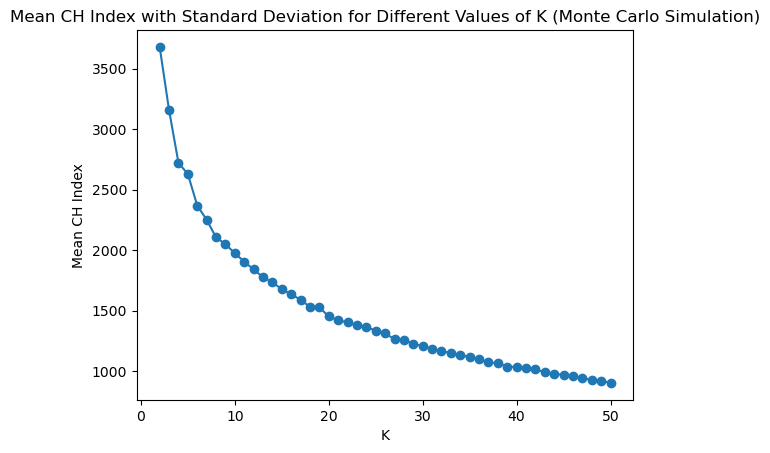

Optimal number of clusters (k) based on mean CH index: 2


In [46]:
k_values = range(2, 51)
ch_scores_matrix = []

# Perform Monte Carlo simulation
for _ in range(50):
    ch_scores = []

    # Perform k-means clustering for different values of k
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=66)
        kmeans.fit(X)
        labels = kmeans.labels_
        ch_score = calinski_harabasz_score(X, labels)
        ch_scores.append(ch_score)

    ch_scores_matrix.append(ch_scores)

ch_scores_matrix = np.array(ch_scores_matrix)

# Calculate the mean and standard deviation of CH index scores across simulations for each k
mean_ch_scores = np.mean(ch_scores_matrix, axis=0)
std_ch_scores = np.std(ch_scores_matrix, axis=0)

# Plot the mean CH index scores with error bars (standard deviation)
plt.errorbar(k_values, mean_ch_scores, yerr=std_ch_scores, marker='o')
plt.title('Mean CH Index with Standard Deviation for Different Values of K (Monte Carlo Simulation)')
plt.xlabel('K')
plt.ylabel('Mean CH Index')
plt.show()

optimal_k = k_values[np.argmax(mean_ch_scores)]
print(f'Optimal number of clusters (k) based on mean CH index: {optimal_k}')

In [12]:
def get_best_cluster_k():
    k_values = range(2, 51)
    silhouette_scores = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k) # not setting random_state
        kmeans.fit(X)
        labels = kmeans.labels_
        silhouette_score_value = silhouette_score(X, labels)
        silhouette_scores.append(silhouette_score_value)
    optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
    print(f'Optimal number of clusters (k) based on Silhouette score: {optimal_k_silhouette}')
    kmeans_optimal = KMeans(n_clusters=optimal_k_silhouette)
    df = data.copy()
    df['Cluster'] = kmeans_optimal.fit_predict(X)
    return df

### (b) Determine which family is the majority

In [13]:
def cluster_majority():    
    df = get_best_cluster_k()
    clustered_data = df.groupby('Cluster')

    majority_family = clustered_data['Family'].agg(lambda x: x.value_counts().index[0])
    majority_genus = clustered_data['Genus'].agg(lambda x: x.value_counts().index[0])
    majority_species = clustered_data['Species'].agg(lambda x: x.value_counts().index[0])

    # Combine the results into a new DataFrame
    cluster_summary = pd.DataFrame({
        'Majority_Family': majority_family,
        'Majority_Genus': majority_genus,
        'Majority_Species': majority_species
    }).reset_index()

    return cluster_summary

### (c) Calculate the average Hamming distance, Hamming score, and Hamming loss

In [79]:
hamming_distances = []
hamming_scores = []
hamming_losses = []

labels_1 = ['Family', 'Genus', 'Species']
labels_2 = ['Majority_Family', 'Majority_Genus', 'Majority_Species']

for i in range(50):
    print(f'For No.{i+1} procedure:')
    cluster_majority_df = cluster_majority()
    print()
    print(cluster_majority_df)
    print()
  
    df_merged = pd.merge(df, cluster_majority_df, on='Cluster')
    
    # distance : true_labels != cluster_labels for all labels
    hamming_distance_family = hamming(df_merged['Family'].values,df_merged['Majority_Family'].values)
    hamming_distance_genus = hamming(df_merged['Genus'].values,df_merged['Majority_Genus'].values)
    hamming_distance_species = hamming(df_merged['Species'].values,df_merged['Majority_Species'].values)
    avg_hamming_distance = (hamming_distance_family + hamming_distance_genus + hamming_distance_species)/3
    hamming_distances.append(avg_hamming_distance)

    hamming_loss_family = hamming_loss(df_merged['Family'].values,df_merged['Majority_Family'].values)
    hamming_loss_genus = hamming_loss(df_merged['Genus'].values,df_merged['Majority_Genus'].values)
    hamming_loss_species = hamming_loss(df_merged['Species'].values,df_merged['Majority_Species'].values)
    avg_hamming_loss = (hamming_loss_family + hamming_loss_genus + hamming_loss_species)/3
    hamming_losses.append(avg_hamming_loss)
    hamming_scores.append(1 - avg_hamming_loss)
    
    #hamming_score_value = 1 - hamming_loss_value 
    #hamming_scores.append(hamming_score_value)

    print(f'Average Hamming distance: {avg_hamming_distance}')
    print(f'Average Hamming loss: {avg_hamming_loss}')
    print(f'Average Hamming score: { 1 - avg_hamming_loss}')
    print('==============================================')

For No.1 procedure:
Optimal number of clusters (k) based on Silhouette score: 4

   Cluster  Majority_Family Majority_Genus        Majority_Species
0        0  Leptodactylidae      Adenomera  AdenomeraHylaedactylus
1        1  Leptodactylidae      Adenomera          AdenomeraAndre
2        2          Hylidae      Hypsiboas       HypsiboasCordobae
3        3          Hylidae      Hypsiboas       HypsiboasCordobae

Average Hamming distance: 0.5130414639796155
Average Hamming loss: 0.5130414639796155
Average Hamming score: 0.4869585360203845
For No.2 procedure:
Optimal number of clusters (k) based on Silhouette score: 4

   Cluster  Majority_Family Majority_Genus        Majority_Species
0        0  Leptodactylidae      Adenomera  AdenomeraHylaedactylus
1        1          Hylidae      Hypsiboas    HypsiboasCinerascens
2        2          Hylidae      Hypsiboas       HypsiboasCordobae
3        3    Dendrobatidae       Ameerega      Ameeregatrivittata

Average Hamming distance: 0.7696548529

Optimal number of clusters (k) based on Silhouette score: 4

   Cluster  Majority_Family Majority_Genus        Majority_Species
0        0  Leptodactylidae      Adenomera  AdenomeraHylaedactylus
1        1          Hylidae      Hypsiboas       HypsiboasCordobae
2        2          Hylidae      Hypsiboas    HypsiboasCinerascens
3        3    Dendrobatidae       Ameerega      Ameeregatrivittata

Average Hamming distance: 0.815427380125087
Average Hamming loss: 0.815427380125087
Average Hamming score: 0.18457261987491302
For No.16 procedure:
Optimal number of clusters (k) based on Silhouette score: 4

   Cluster  Majority_Family Majority_Genus        Majority_Species
0        0          Hylidae      Hypsiboas    HypsiboasCinerascens
1        1  Leptodactylidae      Adenomera  AdenomeraHylaedactylus
2        2    Dendrobatidae       Ameerega      Ameeregatrivittata
3        3          Hylidae      Hypsiboas       HypsiboasCordobae

Average Hamming distance: 0.4290942784340978
Average Hammi

Optimal number of clusters (k) based on Silhouette score: 4

   Cluster  Majority_Family Majority_Genus        Majority_Species
0        0          Hylidae      Hypsiboas       HypsiboasCordobae
1        1  Leptodactylidae      Adenomera  AdenomeraHylaedactylus
2        2    Dendrobatidae       Ameerega      Ameeregatrivittata
3        3          Hylidae      Hypsiboas    HypsiboasCinerascens

Average Hamming distance: 0.44600416956219596
Average Hamming loss: 0.44600416956219596
Average Hamming score: 0.5539958304378041
For No.30 procedure:
Optimal number of clusters (k) based on Silhouette score: 4

   Cluster  Majority_Family Majority_Genus        Majority_Species
0        0    Dendrobatidae       Ameerega      Ameeregatrivittata
1        1  Leptodactylidae      Adenomera  AdenomeraHylaedactylus
2        2          Hylidae      Hypsiboas    HypsiboasCinerascens
3        3          Hylidae      Hypsiboas       HypsiboasCordobae

Average Hamming distance: 0.4006022700949734
Average Ha

Optimal number of clusters (k) based on Silhouette score: 4

   Cluster  Majority_Family Majority_Genus        Majority_Species
0        0          Hylidae      Hypsiboas    HypsiboasCinerascens
1        1  Leptodactylidae      Adenomera  AdenomeraHylaedactylus
2        2          Hylidae      Hypsiboas       HypsiboasCordobae
3        3    Dendrobatidae       Ameerega      Ameeregatrivittata

Average Hamming distance: 0.22177438035672922
Average Hamming loss: 0.22177438035672922
Average Hamming score: 0.7782256196432707
For No.44 procedure:
Optimal number of clusters (k) based on Silhouette score: 4

   Cluster  Majority_Family Majority_Genus        Majority_Species
0        0  Leptodactylidae      Adenomera  AdenomeraHylaedactylus
1        1    Dendrobatidae       Ameerega      Ameeregatrivittata
2        2          Hylidae      Hypsiboas       HypsiboasCordobae
3        3          Hylidae      Hypsiboas    HypsiboasCinerascens

Average Hamming distance: 0.8342830669446375
Average Ha

In [80]:
avg_hamming_distance = np.mean(hamming_distances)
std_hamming_distance = np.std(hamming_distances)

# Print or use the averages as needed
print(f"Average Hamming Distance: {avg_hamming_distance}")
print(f"Standard deviation of Hamming Distance: {std_hamming_distance}")

Average Hamming Distance: 0.6349826268241834
Standard deviation of Hamming Distance: 0.27226023569235874


## 3. ISLR 12.6.2

(a)

Reference:
1. https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/HammingLoss
2. https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff
3. https://hasty.ai/docs/mp-wiki/metrics/hamming-score#hamming-score-in-python
